# Hybrid Bi-LSTM + Bi-GRU Binary Classifier

This notebook demonstrates a complete workflow for text classification using a **hybrid Bi-LSTM + Bi-GRU model**.  

## Features

- **Data Preprocessing**  
  - Cleaning text (removing punctuation, lowercasing, etc.)  
  - Tokenization and sequence padding  

- **Model Architecture**  
  - Embedding layer (pre-trained or trainable)  
  - Bi-directional LSTM and GRU layers  
  - Dense layers with Dropout for regularization  

- **Training**  
  - Binary classification with `sigmoid` activation and `binary_crossentropy` loss  
  - Callbacks: `EarlyStopping` and `ReduceLROnPlateau` to optimize training  

- **Inference**  
  - Predict on test/demo sentences  
  - Hybrid approach for prediction:
    - **Interactive mode**: Enter sentences manually in a terminal environment  
    - **Notebook/demo mode**: Use predefined sentences in Kaggle/Colab  

- **Evaluation & Visualization**  
  - Confusion matrix and classification report  
  - Heatmaps for visualizing metrics  
  - Training vs. validation accuracy and loss curves  

- **Flexible Notebook Workflow**  
  - Works in both **interactive terminal mode** and **non-interactive notebook mode**  
  - Enables clear demonstration of predictions and model performance  


In [1]:
#Importing neccessary libraries, tools and modules
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import re, string

2025-08-15 14:24:51.796179: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755267892.022305      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755267892.088714      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import pandas as pd

# Load the training dataset
train_file_path = "/kaggle/input/imdb-movie-reviews-dataset/train_data (1).csv"
df = pd.read_csv(train_file_path)

# Load the test dataset
test_file_path = "/kaggle/input/imdb-movie-reviews-dataset/test_data (1).csv"
extra_test_df = pd.read_csv(test_file_path)

# Display basic information about the training dataset
print("Training Dataset Shape:", df.shape)
print("\nTraining Dataset Columns:", df.columns.tolist())
print("\nFirst 5 rows of Training Dataset:\n", df.head())

# Display basic information about the extra test dataset
print("\nExtra Test Dataset Shape:", extra_test_df.shape)
print("\nExtra Test Dataset Columns:", extra_test_df.columns.tolist())
print("\nFirst 5 rows of Extra Test Dataset:\n", extra_test_df.head())

Training Dataset Shape: (25000, 2)

Training Dataset Columns: ['0', '1']

First 5 rows of Training Dataset:
                                                    0  1
0  This film is absolutely awful, but nevertheles...  0
1  Well since seeing part's 1 through 3 I can hon...  0
2  I got to see this film at a preview and was da...  1
3  This adaptation positively butchers a classic ...  0
4  Råzone is an awful movie! It is so simple. It ...  0

Extra Test Dataset Shape: (25000, 2)

Extra Test Dataset Columns: ['0', '1']

First 5 rows of Extra Test Dataset:
                                                    0  1
0  I did not enjoy the film Eraser whatsoever. It...  0
1  Be very afraid of anyone who likes this film. ...  0
2  The 3rd and last big screen spin off from the ...  0
3  Barely three and a half years after just scrap...  1
4  I'm a big fan of the demonic puppets. Looking ...  0


In [3]:
import pandas as pd
import re
import string
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords

# Download NLTK stopwords (run once)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# ===== Function to clean text =====
def clean_text(text):
    """
    Cleans input text by:
    1. Removing HTML tags
    2. Removing punctuation and numbers
    3. Converting text to lowercase
    4. Removing stopwords
    5. Removing extra whitespace
    """
    # Remove HTML tags using BeautifulSoup
    text = BeautifulSoup(text, "html.parser").get_text()
    
    # Remove any characters that are not letters or spaces
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove stopwords
    text = " ".join(word for word in text.split() if word not in stop_words)
    
    # Extra cleaning: remove punctuation (redundant but safe)
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    
    # Remove digits (already partially handled)
    text = re.sub(r"\d+", " ", text)
    
    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()
    
    return text

# ===== Apply cleaning to datasets =====
# Preprocess training dataset
df["preprocessed"] = df["0"].apply(clean_text)

# Preprocess extra test dataset
extra_test_df["preprocessed"] = extra_test_df["0"].apply(clean_text)

# ===== Display first few rows of preprocessed data =====
print(df.head())
print(extra_test_df.head())


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                   0  1  \
0  This film is absolutely awful, but nevertheles...  0   
1  Well since seeing part's 1 through 3 I can hon...  0   
2  I got to see this film at a preview and was da...  1   
3  This adaptation positively butchers a classic ...  0   
4  Råzone is an awful movie! It is so simple. It ...  0   

                                        preprocessed  
0  film absolutely awful nevertheless hilarious t...  
1  well since seeing parts honestly say never mad...  
2  got see film preview dazzled typical romantic ...  
3  adaptation positively butchers classic beloved...  
4  rzone awful movie simple seems tried make movi...  
                                                   0  1  \
0  I did not enjoy the film Eraser whatsoever. It...  0   
1  Be very afraid of anyone who likes this film. ...  0   
2  The 3rd and last big screen spin off from the ...  0   
3  Barely three and a half years after just scrap...  1   
4  I'm a big fan of 

In [4]:
from sklearn.model_selection import train_test_split

# Define features and labels
X = df["preprocessed"]
y = df["1"]  # Target column in training set
Extra = extra_test_df["1"]  # Labels in extra test set

# Split the dataset into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Display dataset sizes
print("Train size:", len(X_train))
print("Test size:", len(X_test))
print("Extra Test size:", len(Extra))

# Display class distributions
print("\nClass distribution in training set:\n", y_train.value_counts(normalize=True))
print("\nClass distribution in test set:\n", y_test.value_counts(normalize=True))
print("\nClass distribution in extra test set:\n", Extra.value_counts(normalize=True))
# Display columns
print(df.columns)
print(extra_test_df.columns)

Train size: 20000
Test size: 5000
Extra Test size: 25000

Class distribution in training set:
 1
1    0.5
0    0.5
Name: proportion, dtype: float64

Class distribution in test set:
 1
1    0.5
0    0.5
Name: proportion, dtype: float64

Class distribution in extra test set:
 1
0    0.5
1    0.5
Name: proportion, dtype: float64
Index(['0', '1', 'preprocessed'], dtype='object')
Index(['0', '1', 'preprocessed'], dtype='object')


In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_VOCAB_SIZE = 10000       # Max words to keep in tokenizer
MAX_SEQUENCE_LENGTH = 100    # Max sequence length for padding
EMBEDDING_DIM = 100          # Embedding vector dimension

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")  # Initialize tokenizer
tokenizer.fit_on_texts(df["preprocessed"])  # Fit on training text

X_test_seq = tokenizer.texts_to_sequences(extra_test_df["preprocessed"])  # Convert test text to sequences

X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")  # Pad sequences

y_train = df["1"].values           # Training labels
y_test = extra_test_df["1"].values # Test labels

In [6]:
#Installing googletrans module
!pip install googletrans

In [7]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()                     # Initialize a label encoder
y_train = label_encoder.fit_transform(df["1"])    # Fit encoder on training labels and transform to integers
y_test = label_encoder.transform(extra_test_df["1"])  # Transform test labels using the same encoder mapping

In [8]:
# ======= Data Augmentation Functions =====

import random
from nltk.corpus import wordnet
from googletrans import Translator
import nltk

# Download WordNet and Open Multilingual Wordnet
nltk.download('wordnet')
nltk.download('omw-1.4')

# ---- Synonym Replacement ----
def synonym_replacement(text, n=2):
    """
    Replace up to `n` words in `text` with their synonyms from WordNet.
    """
    words = text.split()                                         # Split text into words
    new_words = words.copy()                                     # Copy list for modification
    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))  # Words with synonyms
    random.shuffle(random_word_list)                             # Shuffle words for random selection
    num_replaced = 0

    for random_word in random_word_list:
        synonyms = wordnet.synsets(random_word)                 # Get synonyms
        if not synonyms:
            continue
        synonym_words = [lemma.name().replace("_", " ") for lemma in synonyms[0].lemmas() if lemma.name() != random_word]  # Exclude original word
        if synonym_words:
            synonym = random.choice(synonym_words)              # Pick a random synonym
            new_words = [synonym if word == random_word else word for word in new_words]  # Replace word
            num_replaced += 1
        if num_replaced >= n:
            break
    return " ".join(new_words)

# ---- Back Translation ----
translator = Translator()                                       # Initialize Google Translator

def back_translate(text, src='en', mid='fr'):
    """
    Translate text to intermediate language and back to English for augmentation.
    """
    try:
        translated = translator.translate(text, src=src, dest=mid).text
        back_translated = translator.translate(translated, src=mid, dest=src).text
        return back_translated
    except Exception as e:
        return text  # fallback if API fails

# ======= Apply Data Augmentation to Training Set =====
augmented_texts = []    # Store augmented texts
augmented_labels = []   # Store corresponding labels

for text, label in zip(df["preprocessed"], y_train):
    # Original text
    augmented_texts.append(text)
    augmented_labels.append(label)
    
    # Synonym replacement augmentation
    aug_syn = synonym_replacement(text, n=2)
    augmented_texts.append(aug_syn)
    augmented_labels.append(label)
    
    # Back translation augmentation
    aug_bt = back_translate(text)
    augmented_texts.append(aug_bt)
    augmented_labels.append(label)

# Print dataset size before and after augmentation
print(f"Original size: {len(df)}, Augmented size: {len(augmented_texts)}")

# ===== Re-tokenize augmented dataset =====
X_train_seq = tokenizer.texts_to_sequences(augmented_texts)               # Convert text to sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")  # Pad sequences
y_train = np.array(augmented_labels)                                       # Convert labels to NumPy array


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
/tmp/ipykernel_19/3405666681.py:48: RuntimeWarning: coroutine 'Translator.translate' was never awaited
  return text  # fallback if API fails


Original size: 25000, Augmented size: 75000


In [9]:
import gdown  # For downloading files from Google Drive or external URLs

# Download GloVe embeddings from Stanford NLP repository
!gdown https://nlp.stanford.edu/data/glove.6B.zip

# Unzip the downloaded GloVe embeddings quietly (no output)
!unzip -q glove.6B.zip

Downloading...
From: https://nlp.stanford.edu/data/glove.6B.zip
To: /kaggle/working/glove.6B.zip
100%|████████████████████████████████████████| 862M/862M [02:39<00:00, 5.42MB/s]


In [10]:
import numpy as np

# ===== Load GloVe embeddings into a dictionary =====
embeddings_index = {}  # Dictionary to store word -> vector mapping
with open("/kaggle/working/glove.6B.100d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()                          # Split line into word + vector values
        word = values[0]                               # First element is the word
        coefs = np.asarray(values[1:], dtype="float32")  # Remaining elements are embedding coefficients
        embeddings_index[word] = coefs                 # Add to dictionary

# ===== Create embedding matrix for Keras Embedding layer =====
embedding_matrix = np.zeros((MAX_VOCAB_SIZE, EMBEDDING_DIM))  # Initialize matrix with zeros

for word, i in tokenizer.word_index.items():
    if i < MAX_VOCAB_SIZE:                                   # Only keep top MAX_VOCAB_SIZE words
        embedding_vector = embeddings_index.get(word)        # Get GloVe vector if exists
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector          # Assign vector to embedding matrix

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, GRU, Dense, Dropout
from tensorflow.keras import regularizers

# ===== Input Layer =====
input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))  # Input for sequences of fixed length

# ===== Embedding Layer =====
embedding_layer = Embedding(
    input_dim=MAX_VOCAB_SIZE,        # Vocabulary size
    output_dim=EMBEDDING_DIM,        # Embedding dimensions
    weights=[embedding_matrix],      # Pretrained GloVe embeddings
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False                  # Freeze embeddings
)(input_layer)

# ===== Bi-LSTM Branch =====
lstm_layer = Bidirectional(
    LSTM(64, return_sequences=False, dropout=0.2)  # 64 units, outputs last hidden state
)(embedding_layer)  # Output shape: (batch_size, 128)

# ===== Bi-GRU Branch =====
gru_layer = Bidirectional(
    GRU(64, return_sequences=False, dropout=0.2)  # 64 units, outputs last hidden state
)(embedding_layer)  # Output shape: (batch_size, 128)

# ===== Merge LSTM + GRU =====
merged_layer = Dense(
    128, 
    activation="relu", 
    kernel_regularizer=regularizers.l2(0.001)      # L2 regularization
)(lstm_layer + gru_layer)  # Element-wise addition of LSTM and GRU outputs
merged_layer = Dropout(0.3)(merged_layer)         # Dropout for regularization

# ===== Output Layer =====
output_layer = Dense(1, activation="sigmoid")(merged_layer)  # Binary classification

# ===== Define Model =====
model = Model(inputs=input_layer, outputs=output_layer)

# ===== Compile Model =====
model.compile(
    loss='binary_crossentropy',      # Binary cross-entropy loss
    optimizer='adam',                # Adam optimizer
    metrics=['accuracy', 'precision', 'recall', 'auc']  # Evaluation metrics
)

# ===== Summary =====
model.summary()  # Print model architecture and parameters

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1755268166.308290      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 100)  │  1,000,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     84,480 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │     63,744 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128)       │          0 │ bidirectional[0]… │
│                     │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        129 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,164,865 (4.44 MB)

 Trainable params: 164,865 (644.00 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [12]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# ===== Early Stopping =====
early_stop = EarlyStopping(
    monitor='val_accuracy',   # Stop training if validation accuracy doesn't improve
    patience=10,              # Wait 10 epochs before stopping
    restore_best_weights=True, # Restore model weights from the epoch with best validation accuracy
    verbose=1
)

# ===== Reduce Learning Rate on Plateau =====
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',   # Reduce LR if validation accuracy plateaus
    factor=0.3,               # Reduce learning rate by factor of 0.3
    patience=5,               # Wait 5 epochs before reducing
    min_lr=1e-6,              # Minimum learning rate
    verbose=1
)

# ===== Model Checkpoint =====
checkpoint = ModelCheckpoint(
    "Hybrid_LSTM_GRU_best_model.keras",       # Filepath to save the best model
    monitor="val_accuracy",                   # Save model based on validation accuracy
    save_best_only=True,                      # Only save the best-performing model
    verbose=1
)

In [13]:
# ===== Train the model =====
history = model.fit(
    X_train_pad,               # Padded training sequences
    y_train,                   # Corresponding labels
    validation_split=0.2,      # Use 20% of training data for validation
    epochs=100,                  # Number of training epochs (increase as needed)
    batch_size=32,             # Mini-batch size
    callbacks=[early_stop, lr_scheduler, checkpoint],  # Callbacks for early stopping, LR scheduling, and saving best model
    verbose=2,                 # Verbosity mode (2 = one line per epoch)
    shuffle=True               # Shuffle training data each epoch
)

Epoch 1/100


I0000 00:00:1755268175.886671      68 cuda_dnn.cc:529] Loaded cuDNN version 90300



Epoch 1: val_accuracy improved from -inf to 0.81740, saving model to Hybrid_LSTM_GRU_best_model.keras
1875/1875 - 60s - 32ms/step - accuracy: 0.7677 - auc: 0.8530 - loss: 0.5099 - precision: 0.7604 - recall: 0.7768 - val_accuracy: 0.8174 - val_auc: 0.8987 - val_loss: 0.4203 - val_precision: 0.8458 - val_recall: 0.7885 - learning_rate: 0.0010
Epoch 2/100

Epoch 2: val_accuracy improved from 0.81740 to 0.83420, saving model to Hybrid_LSTM_GRU_best_model.keras
1875/1875 - 49s - 26ms/step - accuracy: 0.8379 - auc: 0.9174 - loss: 0.3735 - precision: 0.8299 - recall: 0.8471 - val_accuracy: 0.8342 - val_auc: 0.9097 - val_loss: 0.3894 - val_precision: 0.8343 - val_recall: 0.8454 - learning_rate: 0.0010
Epoch 3/100

Epoch 3: val_accuracy improved from 0.83420 to 0.83773, saving model to Hybrid_LSTM_GRU_best_model.keras
1875/1875 - 48s - 26ms/step - accuracy: 0.8678 - auc: 0.9418 - loss: 0.3166 - precision: 0.8621 - recall: 0.8735 - val_accuracy: 0.8377 - val_auc: 0.9151 - val_loss: 0.3968 - va

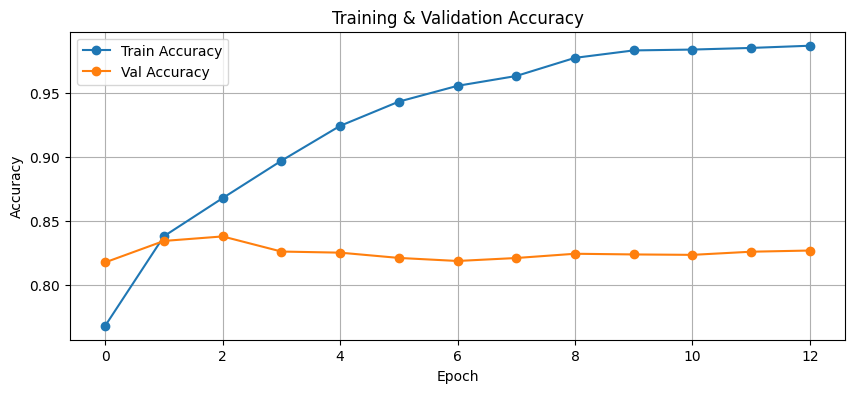

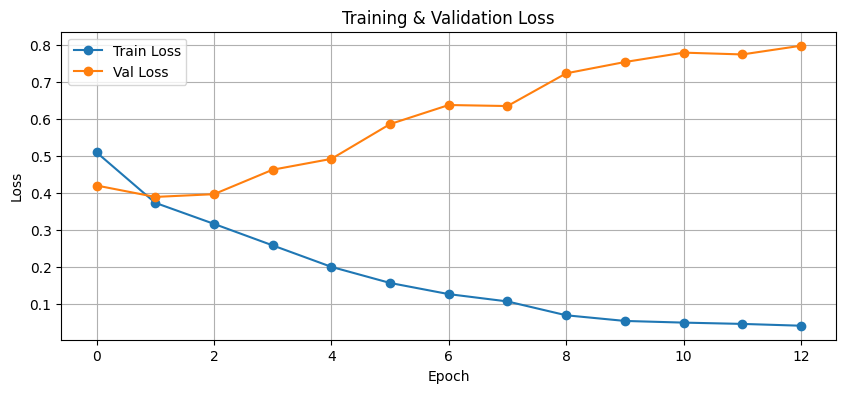

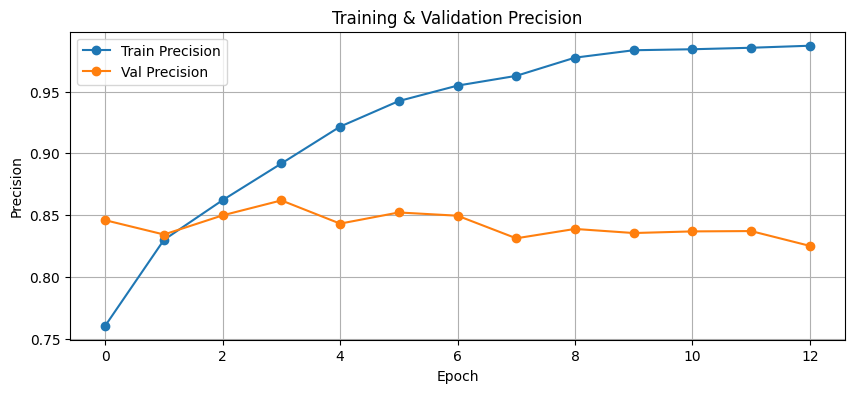

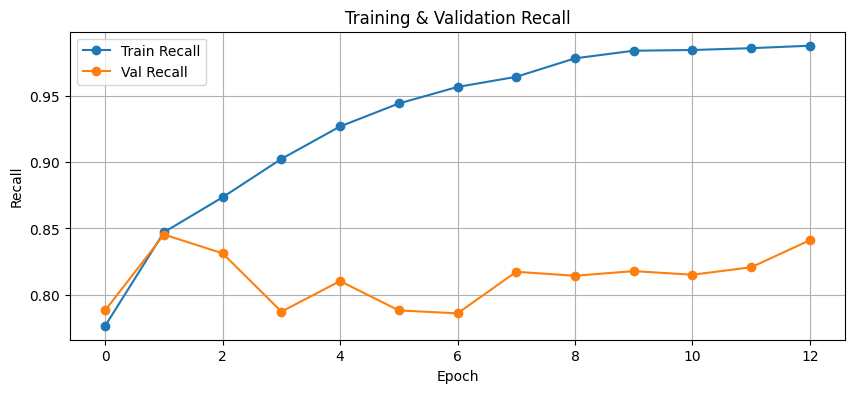

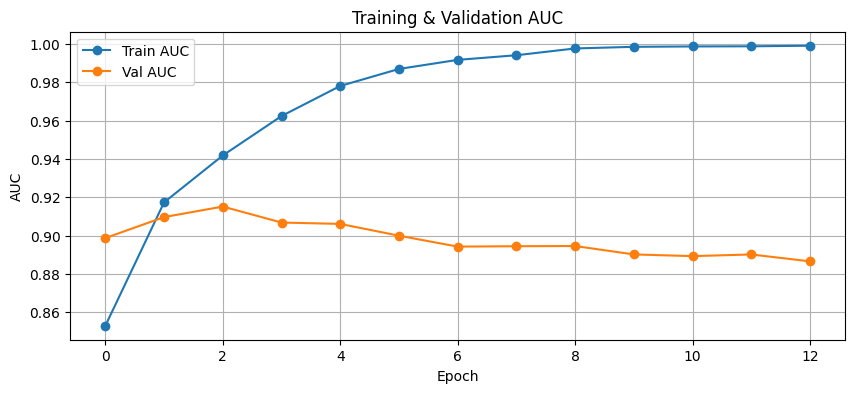

In [14]:
import matplotlib.pyplot as plt

# ===== Plot Training & Validation Accuracy =====
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')       # Training accuracy
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')     # Validation accuracy
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# ===== Plot Training & Validation Loss =====
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss', marker='o')               # Training loss
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')             # Validation loss
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# ===== Plot Training & Validation Precision =====
plt.figure(figsize=(10, 4))
plt.plot(history.history['precision'], label='Train Precision', marker='o')     # Training precision
plt.plot(history.history['val_precision'], label='Val Precision', marker='o')   # Validation precision
plt.title('Training & Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

# ===== Plot Training & Validation Recall =====
plt.figure(figsize=(10, 4))
plt.plot(history.history['recall'], label='Train Recall', marker='o')           # Training recall
plt.plot(history.history['val_recall'], label='Val Recall', marker='o')         # Validation recall
plt.title('Training & Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.show()

# ===== Plot Training & Validation AUC =====
plt.figure(figsize=(10, 4))
plt.plot(history.history['auc'], label='Train AUC', marker='o')                 # Training AUC
plt.plot(history.history['val_auc'], label='Val AUC', marker='o')               # Validation AUC
plt.title('Training & Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# ===== Evaluate Model on Test Set =====
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(
    X_test_pad,          # Padded test sequences
    y_test,              # Test labels
    batch_size=32        # Batch size for evaluation
)

# ===== Print Test Metrics =====
print(f"Test Loss: {test_loss:.4f}")           # Test set loss
print(f"Test Accuracy: {test_accuracy:.4f}")   # Test set accuracy
print(f"Test Precision: {test_precision:.4f}") # Test set precision
print(f"Test Recall: {test_recall:.4f}")       # Test set recall
print(f"Test AUC: {test_auc:.4f}")             # Test set area under ROC curve

782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8371 - auc: 0.9148 - loss: 0.3957 - precision: 0.8403 - recall: 0.8349
Test Loss: 0.4005
Test Accuracy: 0.8327
Test Precision: 0.8382
Test Recall: 0.8246
Test AUC: 0.9133


In [16]:
# Predict probabilities
y_pred_prob = model.predict(X_test_pad)

# Convert probabilities to binary labels (0/1)
y_pred = (y_pred_prob >= 0.5).astype(int)

782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step



Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.84      0.83     12500
           1       0.84      0.82      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



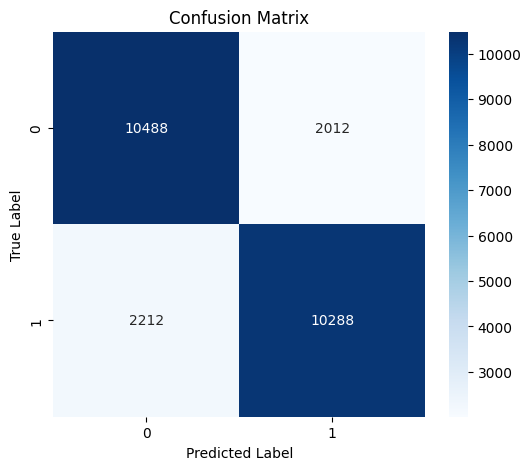

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Classification report
report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", report)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

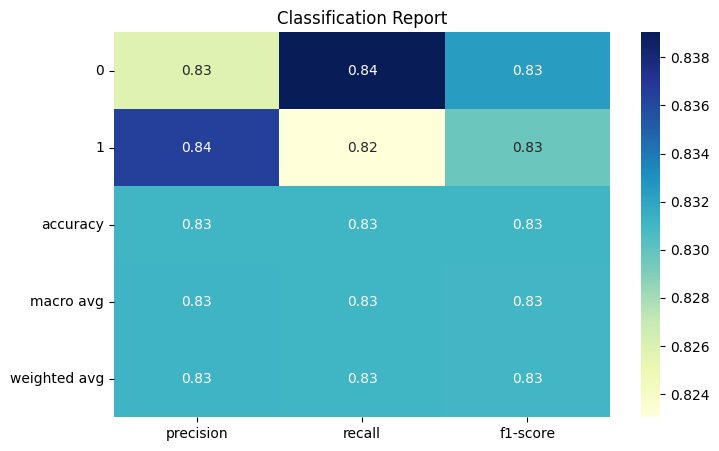

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

# Generate classification report as dict
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report_dict).iloc[:-1, :].T  # exclude accuracy row, transpose

# Plot heatmap
plt.figure(figsize=(8,5))
sns.heatmap(report_df, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Classification Report")
plt.show()

In [19]:
# Save model
model.save("/kaggle/working/Hybrid_LSTM_GRU_last_model.keras")

# Save tokenizer
import joblib
joblib.dump(tokenizer, "/kaggle/working/tokenizer.pkl")

['/kaggle/working/tokenizer.pkl']

In [20]:
import sys
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import joblib

# ===== Load Tokenizer =====
tokenizer = joblib.load("/kaggle/working/tokenizer.pkl")

# ===== Load Bi-LSTM Model =====
model = load_model("/kaggle/working/Hybrid_LSTM_GRU_best_model.keras")

# ===== Config =====
MAX_SEQUENCE_LENGTH = 100  # Same as training

# ===== Demo Sentences =====
demo_sentences = [
    "I really enjoyed this product, it’s fantastic!",
    "This was the worst service I’ve ever had.",
    "It’s okay, nothing special."
]

# ===== Prediction Function =====
def predict_sentiment(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")
    pred_prob = model.predict(padded, verbose=0)[0][0]  # Probability for positive class
    pred_label = 1 if pred_prob >= 0.5 else 0
    sentiment = "Positive" if pred_label == 1 else "Negative"
    return sentiment, pred_label, float(pred_prob)

# ===== Run Predictions for Demo Sentences First =====
print("=== Demo Sentences Prediction ===")
for sentence in demo_sentences:
    sentiment, pred_label, pred_prob = predict_sentiment(sentence)
    print(f"Sentence: {sentence}")
    print(f"Predicted Sentiment: {sentiment} (Label: {pred_label}, Probability: {pred_prob:.4f})\n")

# ===== Check for Interactive Mode =====
try:
    choice = input(
        "Press 0 to enter interactive mode, or any other key to skip: "
    ).strip()
    interactive_mode = (choice == "0")
except Exception:
    interactive_mode = False

# ===== Interactive Mode =====
if interactive_mode:
    print("=== Interactive Bi-LSTM Sentiment Prediction ===")
    while True:
        user_input = input("\nEnter a sentence (or type 'exit' to quit): ")
        if user_input.lower() == "exit":
            print("Exiting interactive mode.")
            break
        sentiment, pred_label, pred_prob = predict_sentiment(user_input)
        print(f"Predicted Sentiment: {sentiment} (Label: {pred_label}, Probability: {pred_prob:.4f})")

=== Demo Sentences Prediction ===
Sentence: I really enjoyed this product, it’s fantastic!
Predicted Sentiment: Positive (Label: 1, Probability: 0.9564)

Sentence: This was the worst service I’ve ever had.
Predicted Sentiment: Negative (Label: 0, Probability: 0.0229)

Sentence: It’s okay, nothing special.
Predicted Sentiment: Negative (Label: 0, Probability: 0.1329)

